In [33]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import rnn as rnn_utils
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
# from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CyclicLR, LambdaLR, ReduceLROnPlateau, MultiStepLR

from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomResizedCrop, Normalize, Pad
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, inception_v3, alexnet
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.inception import Inception_V3_Weights
# from torchvision.models.vgg import VGG16_Weights

from torch_lr_finder import LRFinder

from tqdm.autonotebook import tqdm
# from tqdm.auto import tqdm
from datetime import datetime as dt
import os
import random
from copy import deepcopy
from pathlib import Path
import shutil

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [25]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CyclicLR, LambdaLR, ReduceLROnPlateau, MultiStepLR

from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomResizedCrop, Normalize, Pad

from torch_lr_finder import LRFinder

import os
from pathlib import Path
import random
from tqdm.autonotebook import tqdm

In [34]:
DATA_PATH = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\ArmenianHousePrices/\notebooks/\data')

data = pd.read_csv(os.path.join(DATA_PATH, 'final_data.csv'))

cat_feats_list = list(data.select_dtypes(include=['object']).columns)
remove_cat_list =[
    'description', 'address', 'seller_type', 'total_description',
    'renewed_date', 'seller_id', 'region', 'geo_location', 'estate_type'
]
cat_feats_list = [i for i in cat_feats_list if i not in remove_cat_list]
cat_feats_list = ['Number of Rooms',
 'Renovation',
 'Furniture',
 'New Construction',
 'Construction Type',
 'Number of Bathrooms',
 'Balcony',
 'Elevator']
print(cat_feats_list)

ordinal_feats_list = ['Number of Rooms', 'Number of Bathrooms']

nominal_feats_list = [i for i in cat_feats_list if i not in ordinal_feats_list]

num_feats_list = list(data.select_dtypes(exclude=['object']).columns)
remove_num_feats_list = ['posted_date', 'sqm_price_usd', 'estate_id', 'latitude', 'longitude', 'geo_location']
remove_ordinal_feats_list = [
    'Floor', 'Floors in the Building'
]
ordinal_feats_list.extend(remove_ordinal_feats_list)
cat_feats_list.extend(remove_ordinal_feats_list)
remove_nominal_feats_list = [
    'covered parking', 'outdoor parking', 'garage', 'air conditioner', 'dishwasher',
    'washing machine', 'fridge', 'drying machine', 'stove', 'park view', 'street view', 
    'view of Ararat', 'yard view', 'city view', 'concierge', 'intercom entry', 
    'playground', 'is_capital'
]
nominal_feats_list.extend(remove_nominal_feats_list)
cat_feats_list.extend(remove_nominal_feats_list)
num_feats_list = [i for i in num_feats_list if i not in remove_num_feats_list and i not in cat_feats_list]
num_feats_list = [i for i in num_feats_list if i not in remove_ordinal_feats_list and i not in remove_nominal_feats_list]
# feats_name_list = [col for col in data.columns if col!='']
print(num_feats_list)

feats_name_list = []
feats_name_list.extend(cat_feats_list)
feats_name_list.extend(num_feats_list)

# data = data[data['is_capital']==1]
# data.reset_index(drop=True, inplace=True)
# data.drop(columns='is_capital', inplace=True)
# cat_feats_list.remove('is_capital')
# feats_name_list.remove('is_capital')
# nominal_feats_list.remove('is_capital')

# feats_name_list.append('sqm_price_usd')
# data_train, data_valid = train_test_split(data[feats_name_list], random_state=13)
X_train, X_valid, y_train, y_valid = train_test_split(data[feats_name_list], data['sqm_price_usd'].to_frame(), random_state=13)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)

X_valid = X_scaler.transform(X_valid)
y_valid = y_scaler.transform(y_valid)

# scaled_data_train = scaler.fit_transform(data_train)
# scaled_data_train = pd.DataFrame(scaled_data_train, columns=feats_name_list)
# scaled_data_valid = scaler.transform(data_valid)
# scaled_data_valid = pd.DataFrame(scaled_data_valid, columns=feats_name_list)

# feats_name_list.remove('sqm_price_usd')

# y_train = scaled_data_train['sqm_price_usd'].copy().to_frame()
# X_train = scaled_data_train[feats_name_list].copy()

# y_valid = scaled_data_valid['sqm_price_usd'].copy().to_frame()
# X_valid = scaled_data_valid[feats_name_list].copy()

['Number of Rooms', 'Renovation', 'Furniture', 'New Construction', 'Construction Type', 'Number of Bathrooms', 'Balcony', 'Elevator']
['Ceiling Height', 'Floor Area', 'city_attr_0', 'city_attr_1', 'city_attr_2', 'city_attr_3', 'city_attr_4', 'city_attr_5', 'city_attr_6', 'city_attr_7', 'city_attr_8', 'city_attr_9', 'city_attr_10', 'city_attr_11', 'metro_station_0', 'metro_station_1', 'metro_station_2', 'metro_station_3', 'metro_station_4', 'metro_station_5', 'metro_station_6', 'metro_station_7', 'metro_station_8', 'metro_station_9', 'closest_metro_distance', 'mall_0', 'mall_1', 'mall_2', 'mall_3', 'closest_mall_distance']


In [35]:
class DLAssistant(object):
    
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = None
        self.valid_loader = None
        self.tensorboard_writer = None

        self.train_losses = []
        self.valid_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._create_train_step_fn()
        self.valid_step_fn = self._create_valid_step_fn()

        self.layer_output_dict = {}
        self.hook_handlers_dict = {}

        self.scheduler = None
        self.is_batch_lr_scheduler = False
        self.learning_rates = []

        self.clipping = None

    def to(self, device):

        try:
            self.model = self.model.to(device)
            self.device = device
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.model = self.model.to(self.device)
            print(f"{device} device is not accessable!!!\n{self.device} is used!!!")

    def set_loaders(self, train_loader, valid_loader=None):
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def set_tensorboard(self, name, log_dir='summary'):
        
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

        name_suffix = dt.now().strftime('%Y%m%d_%H%M%S')
        full_name = f"{log_dir}/{name}_{name_suffix}"
        self.tensorboard_writer = SummaryWriter(full_name)

    def _create_train_step_fn(self):

        def get_train_loss(X, y):
            self.model.train()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            if callable(self.clipping):
                self.clipping()

            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        
        return get_train_loss
    
    def _create_valid_step_fn(self):
        
        def get_valid_loss(X, y):
            self.model.eval()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            return loss.item()
        
        return get_valid_loss
    
    def _get_mini_batch_loss(self, validation=False):

        if validation:
            data_loader = self.valid_loader
            step_fn = self.valid_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        n_batches = len(data_loader)

        mini_batch_losses = []

        for i, (X_batch, y_batch) in enumerate(data_loader):
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(X_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if not validation:
                self._step_mini_batch_schedulers(i / n_batches)

        return np.mean(mini_batch_losses)
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass
    
    def train(self, n_epochs, seed=42):

        self.total_epochs += 1

        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):

            train_loss = self._get_mini_batch_loss()
            self.train_losses.append(train_loss)

            with torch.no_grad():
                valid_loss = self._get_mini_batch_loss(validation=True)
                self.valid_losses.append(valid_loss)

            self._step_epoch_schedulers(valid_loss)

            if self.tensorboard_writer is not None:
                scalar_dict = {'train': train_loss}
                if self.valid_loader is not None:
                    scalar_dict.update({'validation': valid_loss})
                self.tensorboard_writer.add_scalars(
                    main_tag = 'losses',
                    tag_scalar_dict = scalar_dict,
                    global_step = epoch
                )

        if self.tensorboard_writer is not None:
            self.tensorboard_writer.flush()

    def show_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.train_losses, label='train', c='blue')
        if self.valid_loader is not None:
            plt.plot(self.valid_losses, label='valid', c='orange')
        plt.yscale('log')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        return fig
    
    def save_results(self, filepath):
        checkpoint_dict = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'total_epochs': self.total_epochs,
            'train_losses': self.train_losses,
            'valid_losses': self.valid_losses
        }
        torch.save(checkpoint_dict, filepath)

    def load_states(self, filepath):
        checkpoint_dict = torch.load(filepath)
        self.model.load_state_dict(checkpoint_dict['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
        self.total_epochs = checkpoint_dict['total_epochs']
        self.train_losses = checkpoint_dict['train_losses']
        self.valid_losses = checkpoint_dict['valid_losses']

        self.model.train()

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.as_tensor(X).float()
        X_tensor = X_tensor.to(self.device)
        pred_y = self.model(X_tensor).detach().cpu().numpy()
        self.model.train()
        return pred_y

    def count_parameters(self):
        parameter_number_list = [p.numel() for p in self.model.parameters() if p.requires_grad]
        return sum(parameter_number_list)

    def attach_hook(self, layers_to_hook_list, hook_fn=None):

        modules_list = list(self.model.named_modules())[1:]
        layer_names_dict = {elem[1]: elem[0] for elem in modules_list}

        self.layer_output_dict = {}

        if hook_fn is None:

            def hook_fn(layer, inputs, outputs):
                layer_name = layer_names_dict[layer]
                output_values = outputs.detach().cpu().numpy()
                if self.layer_output_dict[layer_name] is None:
                    self.layer_output_dict[layer_name] = output_values
                else:
                    self.layer_output_dict[layer_name] = np.concatenate(
                        [self.layer_output_dict[layer_name], output_values]
                    )

        for layer_name, layer in modules_list:
            if layer_name in layers_to_hook_list:
                self.layer_output_dict[layer_name] = None
                self.hook_handlers_dict[layer_name] = layer.register_forward_hook(hook_fn)

    def remove_hook(self):
        for handle in self.hook_handlers_dict.values():
            handle.remove()
        self.hook_handlers_dict = {}

    def show_metric(self, X, y, metric, is_classification=False, threshold=0.5):

        self.model.eval()
        X = torch.as_tensor(X).float()
        y_hat = self.model(X.to(self.device))
        self.model.train()

        if is_classification:
            
            if y_hat.size()[1] > 1:
                _, predicted_class = torch.max(y_hat, 1)
                predicted_class = predicted_class.detach().cpu().numpy()
            else:
                predicted_class = (torch.sigmoid(y_hat) > threshold).long()
                predicted_class = predicted_class.detach().cpu().numpy()

            return metric(y, predicted_class)

        else:

            return metric(y, y_hat.detach().cpu().numpy())
    
    @staticmethod
    def apply_fn_over_loader(loader, func, reduce='sum'):

        results = [func(X, y) for X, y in loader]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.mean(axis=0)

        return results

    @staticmethod
    def get_stats_per_channel(images, labels):
        n_samples, n_channels, height, width = images.size()
        flattened_images = images.reshape(n_samples, n_channels, -1)
        means = flattened_images.mean(axis=2)
        stds = flattened_images.std(axis=2)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        n_samples = torch.tensor([n_samples]*n_channels).float()
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def create_normalizer(loader):
        total_samples, total_means, total_stds = DLAssistant.apply_fn_over_loader(
            loader, DLAssistant.get_stats_per_channel
        )
        norm_mean = total_means / total_samples
        norm_stds = total_stds / total_samples
        return Normalize(norm_mean, norm_stds)

    @staticmethod
    def create_lr_fn(start_lr, end_lr, n_iter, lr_mode='exp'):
        if lr_mode == 'linear':
            lr_factor = (end_lr/start_lr - 1) / n_iter
            def lr_fn(iteration):
                return 1 + lr_factor * iteration
        if lr_mode == 'exp':
            lr_factor = np.log(end_lr/start_lr) / n_iter
            def lr_fn(iteration):
                return np.exp(lr_factor) ** iteration
        return lr_fn

    def lr_range_test(self, data_loader, end_lr, n_iter=100, lr_mode='exp', ewma_param=0.5):

        initial_state_dict = {
            'model': deepcopy(self.model.state_dict()),
            'optimizer': deepcopy(self.optimizer.state_dict())
        }

        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
        lr_fn = DLAssistant.create_lr_fn(start_lr, end_lr, n_iter, lr_mode)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        tracking_dict = {'loss': [], 'lr': []}

        current_iteration = 0

        for X_batch, y_batch in data_loader:

            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            y_hat = self.model(X_batch)
            loss = self.loss_fn(y_hat, y_batch)

            tracking_dict['lr'].append(scheduler.get_last_lr()[0])

            if len(tracking_dict['loss']) == 0:
                tracking_dict['loss'].append(loss.item())
            else:
                tracking_dict['loss'].append((1-ewma_param)*tracking_dict['loss'][-1] + ewma_param*loss.item())

            loss.backward()
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

            current_iteration += 1

            if current_iteration == n_iter:
                break

        self.model.load_state_dict(initial_state_dict['model'])
        self.optimizer.load_state_dict(initial_state_dict['optimizer'])
            
        fig = plt.figure(figsize=(10, 6))
        plt.plot(tracking_dict['lr'], tracking_dict['loss'])
        if lr_mode == 'exp':
            plt.xscale('log')
        plt.xlabel('learning rate')
        plt.ylabel('loss')

        return tracking_dict, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_lr_scheduler(self, scheduler):
        if scheduler.optimizer == self.optimizer:
            self.scheduler = scheduler
            if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or\
                isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or\
                isinstance(scheduler, optim.lr_scheduler.Cosine)):
                self.is_batch_lr_scheduler = True
            else:
                self.is_batch_lr_scheduler = False

    def _step_epoch_schedulers(self, valid_loss):
        if self.scheduler is not None:
            if not self.is_batch_lr_sheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(valid_loss)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda x: x['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def _step_mini_batch_schedulers(self, frac_epoch):
        if self.scheduler is not None:
            if self.is_batch_lr_sheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
                    self.scheduler.step(self.total_epochs + frac_epoch)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda x: x['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def set_clip_grad_value(self, clip_value):
        self.clipping = lambda: nn.utils.clip_grad_value_(
            self.model.parameters(),
            clip_value=clip_value
        )

    def set_clip_grad_norm(self, max_norm, norm_type=2):
        self.clipping = lambda: nn.utils.clip_grad_norm_(
            self.model.parameters(),
            max_norm, norm_type
        )

    def remove_clip(self):
        if isinstance(self.clipping, list):
            for handle in self.clipping:
                handle.remove()
        self.clipping = None

    def set_clip_grad_backprop(self, clip_value):

        if self.clipping is None:
            self.clipping = []
        
        for p in self.model.parameters():
            if p.requires_grad:
                func = lambda grad: torch.clamp(grad, -clip_value, clip_value)
                handle = p.register_hook(func)
                self.clipping.append(handle)

In [36]:
# X_train_tensor = torch.as_tensor(X_train.values).float()
# y_train_tensor = torch.as_tensor(y_train.values).float()

# X_valid_tensor = torch.as_tensor(X_valid.values).float()
# y_valid_tensor = torch.as_tensor(y_valid.values).float()

X_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

X_valid_tensor = torch.as_tensor(X_valid).float()
y_valid_tensor = torch.as_tensor(y_valid).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=32
)

In [37]:
model = nn.Sequential()
model.add_module('linear1', nn.Linear(58, 116))
model.add_module('relu1', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.2))
model.add_module('linear2', nn.Linear(116, 256))
model.add_module('relu2', nn.ReLU())
model.add_module('dropout2', nn.Dropout(0.3))
model.add_module('linear3', nn.Linear(256, 512))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout3', nn.Dropout(0.3))
model.add_module('linear4', nn.Linear(512, 256))
model.add_module('relu4', nn.ReLU())
model.add_module('dropout4', nn.Dropout(0.3))
model.add_module('linear5', nn.Linear(256, 128))
model.add_module('relu5', nn.ReLU())
model.add_module('dropou5', nn.Dropout(0.3))
model.add_module('linear6', nn.Linear(128, 1))

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [38]:
# dl_assistent = DLAssistant(model, loss_fn, optimizer)
# dl_assistent.lr_range_test(data_loader=train_loader, end_lr=0.03, n_iter=100, lr_mode='exp', ewma_param=0.5);
# # dl_assistent.set_loaders(train_loader, valid_loader)
# # # dl_assistent.set_tensorboard(name='class_linear_reg')
# # dl_assistent.train(n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.43E-02


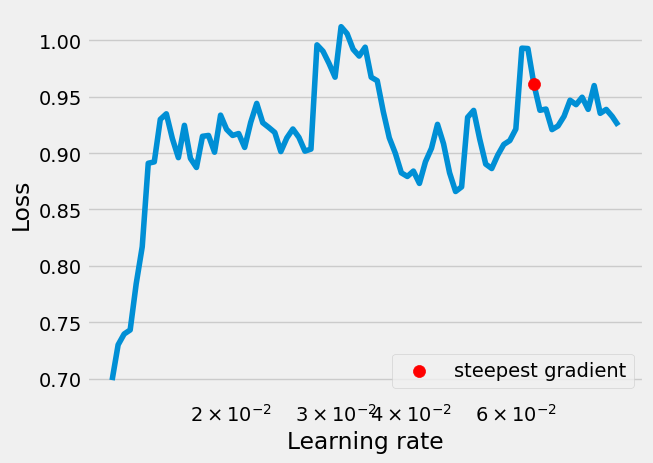

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_loader=train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [40]:
new_optimizer = optim.SGD(model.parameters(), lr=6.43E-02)

n_cycle_epochs = 5
step_size_up = int(len(train_loader) * n_cycle_epochs / 2)

# scheduler1 = StepLR(new_optimizer, step_size=4, gamma=0.5)
scheduler2 = CyclicLR(new_optimizer, base_lr=1e-4, max_lr=6.43E-02, step_size_up=step_size_up, mode='triangular')
# scheduler3 = CyclicLR(new_optimizer, base_lr=1e-4, max_lr=6.43E-02, step_size_up=step_size_up, mode='triangular2')
# scheduler4 = CyclicLR(new_optimizer, base_lr=1e-4, max_lr=6.43E-02, step_size_up=step_size_up, mode='exp_range', gamma=np.sqrt(.5))

dl_assistent = DLAssistant(model, loss_fn, optimizer)
dl_assistent.set_optimizer(new_optimizer)
dl_assistent.set_lr_scheduler(scheduler2)
dl_assistent.set_loaders(train_loader, valid_loader)
# dl_assistent.set_tensorboard(name='class_linear_reg')
dl_assistent.train(n_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

AttributeError: 'DLAssistant' object has no attribute 'is_batch_lr_sheduler'

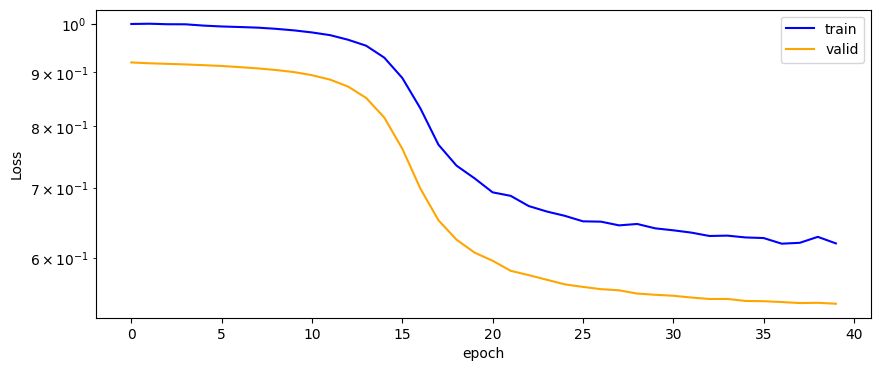

In [19]:
dl_assistent.show_losses();

In [20]:
temp_X, temp_y = next(iter(valid_loader))

temp_df = pd.DataFrame()
temp_df['pred'] = [i[0] for i in list(dl_assistent.predict(temp_X))]
temp_df['true'] = temp_y.numpy()
temp_df['pred_rescaled'] = y_scaler.inverse_transform(temp_df['pred'].to_frame())
temp_df['true_rescaled'] = y_scaler.inverse_transform(temp_df['true'].to_frame())
temp_df['diff'] = temp_df['true_rescaled'] - temp_df['pred_rescaled'] 
temp_df

,pred,true,pred_rescaled,true_rescaled,diff
0,-0.470936,-0.252384,1566.970215,1792.207764,225.237549
1,0.528759,0.846327,2597.246094,2924.528320,327.282227
2,-0.397091,-0.899788,1643.074585,1125.000000,-518.074585
3,0.926404,1.024458,3007.054688,3108.107910,101.053223
4,-0.551550,-0.091759,1483.890625,1957.746460,473.855835
5,-0.389013,-0.156229,1651.399170,1891.304321,239.905151
6,-0.632544,-0.341855,1400.418823,1700.000000,299.581177
7,-0.589708,-0.664074,1444.565796,1367.924438,-76.641357
8,-0.058990,-0.374199,1991.518066,1666.666626,-324.851440
9,-1.116099,-1.458254,902.072510,549.450562,-352.621948
